In [720]:
import re, time, warnings, os, sys, copy
from typing import Union, Dict
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

In [1023]:
from subject_rerp_mt1 import load_eeg

# load sample eeg data
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid
eeg, info = load_eeg(f'./data/preprocessed/eeg/sub{sid}/rsa-MT1-epo.fif', fs = 200)
dir_out = f'./data/processed/eeg/sub{sid}/'

# load sample behaviour
df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
beh = df.loc[(df.type == data.defs.TRIAL_MT_MAIN) | (df.type == data.defs.TRIAL_MT_CONTROL) | (df.type == data.defs.TRIAL_MT_PRACTICE)].reset_index(drop = True)

with gzip.open(f'{dir_out}rec-data.pkl.gz', 'rb') as f:
    (_, _, labels, _, _, _, _, _, _, _, _) = pickle.load(f)

# load inc-inv
with gzip.open(f'./data/results/rerp-mt2-c0-i1-k5-z0-s0-b0-inv.pkl.gz', 'rb') as f:
    r_inc_inv, os_inc_inv, ct_inc_inv = pickle.load(f)

# load inc-spc
with gzip.open(f'./data/results/rerp-mt2-c0-i1-k5-z0-s0-b0-spc.pkl.gz', 'rb') as f:
    r_inc_spc, os_inc_spc, ct_inc_spc = pickle.load(f)

# load con-inv
with gzip.open(f'./data/results/rerp-mt2-c1-i0-k5-z0-s0-b0-inv.pkl.gz', 'rb') as f:
    r_con_inv, os_con_inv, ct_con_inv = pickle.load(f)

# load con-spc
with gzip.open(f'./data/results/rerp-mt2-c1-i0-k5-z0-s0-b0-spc.pkl.gz', 'rb') as f:
    r_con_spc, os_con_spc, ct_con_spc = pickle.load(f)

# load coefs inc-inv
with gzip.open(f'./data/results/rerp-mt2-ko-m2-c0-i1-k5-z0-s0-b0-inv.pkl.gz', 'rb') as f:
    R2_inc_inv, cb_inc_inv = pickle.load(f)
    
# load coefs con-spc
with gzip.open(f'./data/results/rerp-mt2-ko-m2-c1-i0-k5-z0-s0-b0-spc.pkl.gz', 'rb') as f:
    R2_con_spc, cb_con_spc = pickle.load(f)

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_26278/3983797849.py:152: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)
/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_26278/3983797849.py:203: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)


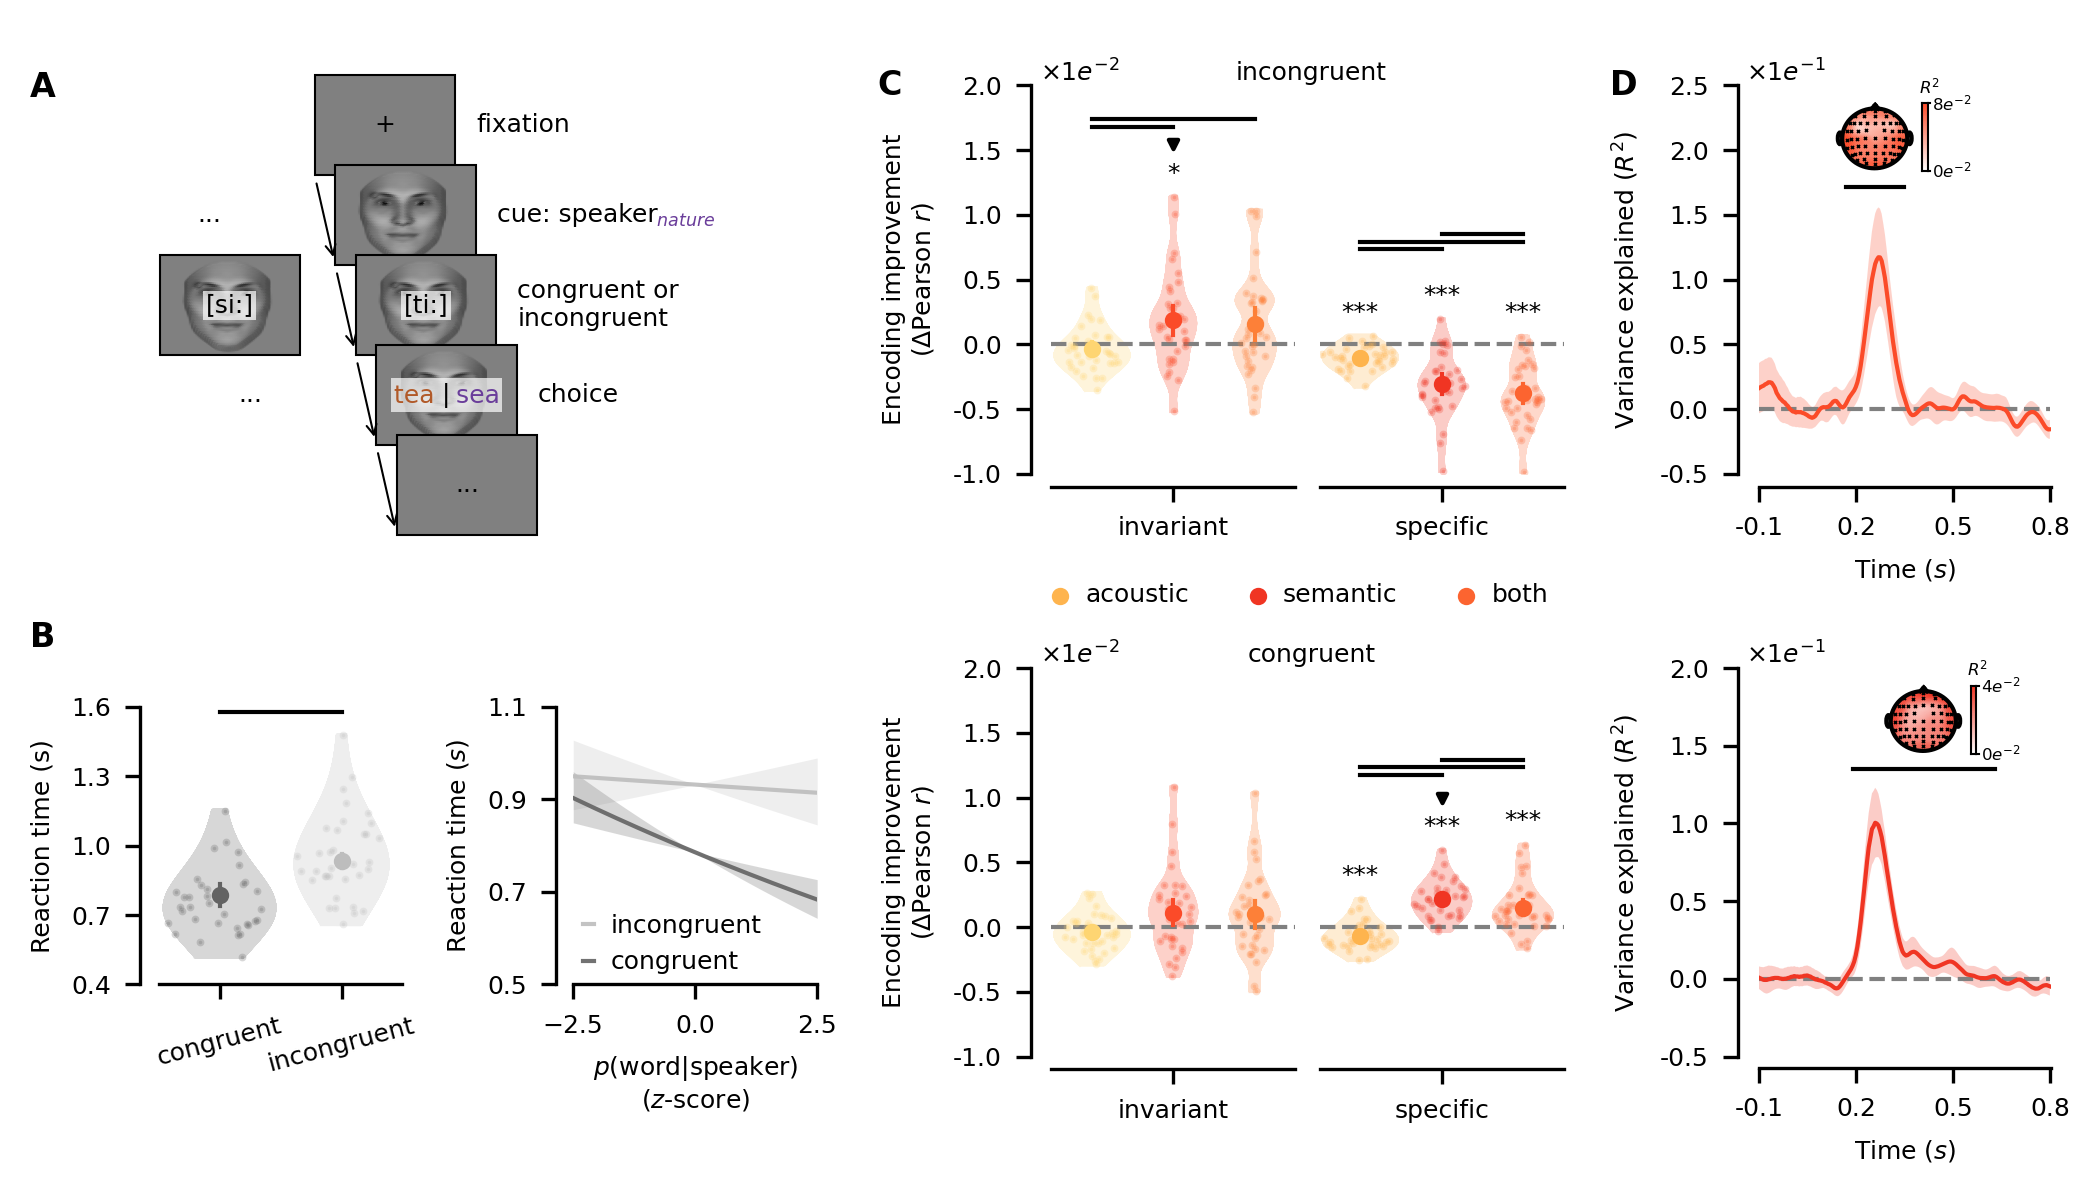

In [ ]:
import seaborn as sns

C_s = pub.colours.equidistant('Paired', k = 12)
C = pub.colours.equidistant('tab20c', k = 20)

context_labels = dict(outdoor = 'nature', essen = 'food', fashion = 'fashion',
                      politik = 'politics', unterhaltung = 'arts', technik = 'tech')
order = np.array(['outdoor', 'essen', 'fashion', 'politik', 'unterhaltung', 'technik'])

colours = dict(outdoor = C_s[9], essen = C_s[11], fashion = C_s[5], 
               politik = C_s[7], unterhaltung = C_s[1], technik = C_s[3])

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

fig, ax = pub.figure(figsize = (7.0, 4.0))

'''
add violins
'''

ax_con_inv = ax.inset_axes([0.65 - 0.15 -0.0125, 0.075, 0.125, 0.35])
ax_con_spc = ax.inset_axes([0.625, 0.075, 0.125, 0.35])
ax_inc_inv = ax.inset_axes([0.65 - 0.15 - 0.0125, 0.6, 0.125, 0.35])
ax_inc_spc = ax.inset_axes([0.625, 0.6, 0.125, 0.35])
ax_con_cof = ax.inset_axes([0.85, 0.075, 0.15, 0.35])
ax_inc_cof = ax.inset_axes([0.85, 0.6, 0.15, 0.35])

d_inc_inv = (r_inc_inv[:,1:] - r_inc_inv[:,0,None]).T
d_inc_spc = (r_inc_spc[:,1:] - r_inc_spc[:,0,None]).T
d_con_inv = (r_con_inv[:,1:] - r_con_inv[:,0,None]).T
d_con_spc = (r_con_spc[:,1:] - r_con_spc[:,0,None]).T

bw_x = np.array([d_inc_inv, d_inc_spc, d_con_inv, d_con_spc]).flatten()
bw = pub.dist._bandwidth_botev(bw_x)
absmin, absmax = bw_x.min(), bw_x.max()
#absmax = np.abs([absmin, absmax]).max() * 1.4
absmax = 0.015

for ax_i in [ax_con_inv, ax_con_spc, ax_inc_inv, ax_inc_spc]:
    ax_i.set_ylim([-0.01, 0.02])
    ax_i.set_xlim([-0.5, 2.5])
    ax_i.set_xticks([1])
    ax_i.plot([-0.5, 2.5], [0, 0], color = 'gray', linestyle = '--')
    ax_i.spines['bottom'].set_position(('data', -0.011))


pub.dist.violins(d_inc_inv, labels = ['acoustic', 'semantic', 'both'], scatter_dep = False, colours = cols_inv, jitter = True, jitter_max = 1.75 * bw, kernel_bandwidth = bw, ax = ax_inc_inv)
pub.dist.violins(d_inc_spc, labels = ['acoustic', 'semantic', 'both'], scatter_dep = False, colours = cols_spc, jitter = True, jitter_max = 1.75 * bw, kernel_bandwidth = bw, ax = ax_inc_spc)
pub.dist.violins(d_con_inv, labels = ['acoustic', 'semantic', 'both'], scatter_dep = False, colours = cols_inv, jitter = True, jitter_max = 1.75 * bw, kernel_bandwidth = bw, ax = ax_con_inv)
pub.dist.violins(d_con_spc, labels = ['acoustic', 'semantic', 'both'], scatter_dep = False, colours = cols_spc, jitter = True, jitter_max = 1.75 * bw, kernel_bandwidth = bw, ax = ax_con_spc)

ax_inc_inv.set_yticks(np.arange(-0.01, 0.021, 0.005))
ax_inc_inv.set_yticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0', '1.5', '2.0'])
ax_inc_inv.set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
ax_con_inv.set_yticks(np.arange(-0.01, 0.021, 0.005))
ax_con_inv.set_yticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0', '1.5', '2.0'])
ax_con_inv.set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
ax_inc_inv.spines['left'].set_position(('data', -0.75))
ax_con_inv.spines['left'].set_position(('data', -0.75))

ax_inc_inv.set_xticklabels(['invariant'])
ax_inc_spc.set_xticklabels(['specific'])
ax_con_inv.set_xticklabels(['invariant'])
ax_con_spc.set_xticklabels(['specific'])
ax_inc_spc.set_yticks([])
ax_con_spc.set_yticks([])
ax_inc_spc.spines[['top', 'left', 'right']].set_visible(False)
ax_con_spc.spines[['top', 'left', 'right']].set_visible(False)
sns.despine(ax = ax_inc_inv)
sns.despine(ax = ax_con_inv)

coff = 0.0009

for c_i, a_i, r_i in zip([ct_inc_inv, ct_inc_spc, ct_con_inv, ct_con_spc],
                         [ax_inc_inv, ax_inc_spc, ax_con_inv, ax_con_spc],
                         [d_inc_inv, d_inc_spc, d_con_inv, d_con_spc]):
    sigs = 5.0
    
    for k_i in c_i:
        # determine where we are
        i, j = k_i.split(' ')[1].split('-')
        i, j = int(i), int(j)
        i, j = i - 1, j - 1

        # grab contrast
        con = c_i[k_i]
        pv = con['p_cor']

        if j == -1:
            if pv > .05: continue
            
            xy = (i, r_i[i,:].max() + 2 * coff)
            a_i.annotate(pub.significance.__sig_from_p(pv), xy = xy, xytext = xy, ha = 'center', va = 'center', annotation_clip = False)
        else:
            if pv > .05: continue
            
            xs = [i, j]
            ys = [r_i.max() + coff + sigs * coff] * 2
            a_i.plot(xs, ys, color = 'black')
            
            sigs += 0.65

ax_inc_inv.scatter([1], [d_inc_inv[1,:].max() + coff + 3.5 * coff], marker = 'v', s = 5, color = 'black')
ax_con_spc.scatter([1], [d_con_spc[1,:].max() + coff + 3.5 * coff], marker = 'v', s = 5, color = 'black')

'''
add coefs
'''

cluster = cb_inc_inv['ß_9'][0]
chs = cluster['chs_i']
tmin, tmax = cluster['tmin'], cluster['tmax']
ß = R2_inc_inv[:,chs,9,:].mean(axis = 1)
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])
maxval = (mu + 1.96 * se).max()

ax_inc_cof.plot(t*0, color = 'gray', linestyle = '--')
ax_inc_cof.fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_inv[1], alpha = 0.25)
ax_inc_cof.plot(ß.mean(axis = 0), color = cols_inv[1])
ax_inc_cof.plot([tmin, tmax], [1.1 * maxval, 1.1 * maxval], color = 'black')

mp = tmin + (tmax - tmin) / 2
mp = mp / 181
mp = mp - 0.15
ax_topo = ax_inc_cof.inset_axes([mp, 0.75, 0.3, 0.2]); ax_topo.axis('off')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'white', cols_inv[1]])
w = R2_inc_inv[:,:,9,tmin:tmax].mean(axis = (0, 2))
_plot_topo_inlay(w, info, cmap = cmap, ax = ax_topo, sensors = False, highlight = chs)

ax_col_cof = ax_inc_cof.inset_axes([mp+0.31, 0.78, 0.02, 0.175]); ax_col_cof.axis('off')
ax_col_cof.set_xlim([0, 1])
ax_col_cof.set_ylim([0, 1])
ax_col_cof.plot([0, 1], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 1], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 0], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
wmax = w.max()
ax_col_cof.annotate(fr'${int(np.round(wmax*100))}e^{{-2}}$', fontsize = 4, xy = (1.75, 1), xytext = (1.75, 1.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(fr'$0e^{{-2}}$', fontsize = 4, xy = (1.75, 0.0), xytext = (1.75, 0.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(r'$R^2$', fontsize = 4, xy = (1.25, 1.25), xytext = (1.25, 1.25), ha = 'center', va = 'center', annotation_clip = False)
cb_x = np.linspace(0, 1, 5)
cb_y = np.linspace(0, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)

ax_inc_cof.set_ylim([-0.05, 0.25])
ax_inc_cof.set_ylabel(r'Variance explained ($R^2$)')
ax_inc_cof.set_yticks(np.arange(-0.05, 0.26, 0.05), labels = ['-0.5', '0.0', '0.5', '1.0', '1.5', '2.0', '2.5'])
ax_inc_cof.set_xticks(np.arange(0, 181, 60))
ax_inc_cof.set_xticklabels(np.round(np.arange(-20, 161, 60) * 5e-3, 2))
ax_inc_cof.set_xlim([0, 181])
ax_inc_cof.set_xlabel(r'Time ($s$)')
sns.despine(ax = ax_inc_cof)
ax_inc_cof.spines['left'].set_position(('data', -13))
ax_inc_cof.spines['bottom'].set_position(('data', -0.06))

cluster = cb_con_spc['ß_11'][0]
chs = cluster['chs_i']
tmin, tmax = cluster['tmin'], cluster['tmax']
ß = R2_con_spc[:,chs,11,:].mean(axis = 1)
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])
maxval = (mu + 1.96 * se).max()

ax_con_cof.plot(t*0, color = 'gray', linestyle = '--')
ax_con_cof.fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_spc[1], alpha = 0.25)
ax_con_cof.plot(ß.mean(axis = 0), color = cols_spc[1], label = 'speaker-specific\nsemantic surprisal')
ax_con_cof.plot([tmin, tmax], [1.1 * maxval, 1.1 * maxval], color = 'black')

mp = tmin + (tmax - tmin) / 2
mp = mp / 181
mp = mp - 0.15
ax_topo = ax_con_cof.inset_axes([mp, 0.75, 0.3, 0.2]); ax_topo.axis('off')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'white', cols_spc[1]])
w = R2_con_spc[:,:,11,tmin:tmax].mean(axis = (0, 2))
_plot_topo_inlay(w, info, cmap = cmap, ax = ax_topo, sensors = False, highlight = chs)

ax_col_cof = ax_con_cof.inset_axes([mp+0.31, 0.78, 0.02, 0.175]); ax_col_cof.axis('off')
ax_col_cof.set_xlim([0, 1])
ax_col_cof.set_ylim([0, 1])
ax_col_cof.plot([0, 1], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 1], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 0], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
wmax = w.max()
ax_col_cof.annotate(fr'${int(np.round(wmax*100))}e^{{-2}}$', fontsize = 4, xy = (1.75, 1), xytext = (1.75, 1.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(fr'$0e^{{-2}}$', fontsize = 4, xy = (1.75, 0.0), xytext = (1.75, 0.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(r'$R^2$', fontsize = 4, xy = (1.25, 1.25), xytext = (1.25, 1.25), ha = 'center', va = 'center', annotation_clip = False)
cb_x = np.linspace(0, 1, 5)
cb_y = np.linspace(0, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)

ax_con_cof.set_ylim([-0.05, 0.2])
ax_con_cof.set_ylabel(r'Variance explained ($R^2$)')
ax_con_cof.set_yticks(np.arange(-0.05, 0.21, 0.05), labels = ['-0.5', '0.0', '0.5', '1.0', '1.5', '2.0'])
ax_con_cof.set_xticks(np.arange(0, 181, 60))
ax_con_cof.set_xticklabels(np.round(np.arange(-20, 161, 60) * 5e-3, 2))
ax_con_cof.set_xlim([0, 181])
ax_con_cof.set_xlabel(r'Time ($s$)')
sns.despine(ax = ax_con_cof)
ax_con_cof.spines['left'].set_position(('data', -13))
ax_con_cof.spines['bottom'].set_position(('data', -0.0575))

'''
some cosmetic touch ups & labelling
'''

pub.cosmetics.legend(ax = ax_con_spc, loc = 'upper left', bbox_to_anchor = (-1.15, 1.225), ncols = 3,
                     borderpad = 0.0, handletextpad = 0.25, borderaxespad = 0.1)
ax_con_inv.annotate(r'$\times1e^{-2}$', xy = (-0.5, 0.021), xytext = (-0.15, 0.021), ha = 'center', va = 'center', annotation_clip = False)
ax_inc_inv.annotate(r'$\times1e^{-2}$', xy = (-0.5, 0.021), xytext = (-0.15, 0.021), ha = 'center', va = 'center', annotation_clip = False)
ax_con_cof.annotate(r'$\times1e^{-1}$', xy = (17, 0.2085), xytext = (17, 0.2085), ha = 'center', va = 'center', annotation_clip = False)
ax_inc_cof.annotate(r'$\times1e^{-1}$', xy = (17, 0.26), xytext = (17, 0.26), ha = 'center', va = 'center', annotation_clip = False)
ax_con_spc.annotate(r'congruent', xy = (-0.6, 2.0e-2), xytext = (-0.6, 2.1e-2), ha = 'center', va = 'center', annotation_clip = False)
ax_inc_spc.annotate(r'incongruent', xy = (-0.6, 2.0e-2), xytext = (-0.6, 2.1e-2), ha = 'center', va = 'center', annotation_clip = False)

'''
add procedure
'''

ax_design = ax.inset_axes([0.05, 0.5, 0.33, 0.495]); ax_design.axis('off')

# add design plot
pub.graphs.procedure([dict(T = 'text', stimulus = '+', delay = '', duration = 'fixation'),
                      dict(T = 'image', stimulus = './data/raw/misc/faces/face7_piercing2.png', delay = '', duration = r'cue: speaker'),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face7_piercing2.png', '[ti:]'), delay = '', duration = r'congruent or' + '\n' + r'incongruent', style = dict(bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7))),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face7_piercing2.png', r'      $|$       '), delay = '', duration = r'choice', style = dict(bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7))),
                      dict(T = 'text', stimulus = '...')], spacing_x = 0.35, offset_x = 1.5, offset_y = 2, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = '        sea', style = dict(color = colours['outdoor']))], 
                      spacing_x = 0.35, offset_x = 2.545, offset_y = -3.415, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = 'tea        ', style = dict(color = colours['essen']))], 
                      spacing_x = 0.35, offset_x = 2.545, offset_y = -3.415, show_delay = False, ax = ax_design)
pub.graphs.procedure([dict(T = 'text-only', stimulus = '...'),
                      dict(T = 'image-text', stimulus = ('./data/raw/misc/faces/face7_piercing2.png', '[si:]'), style = dict(clip_on = False, bbox = dict(fc = 'white', ec = 'None', boxstyle = 'square,pad=0.1', alpha = .7))),
                      dict(T = 'text-only', stimulus = '...')],
                      spacing_x = 0.35, offset_x = -1.5, offset_y = 0.2, show_delay = False, ax = ax_design)
ax_design.set_xlim([-0.5, 10.5])
ax_design.set_ylim([-8, 3])

ax_design.annotate(r'             $_{nature}$', xy = (5.575, -0.75), xytext = (5.575, -0.75), color = colours['outdoor'], annotation_clip = False)

'''
add behavioural results (categorical)
'''

ax_cat = ax.inset_axes([0.03, 0.14, 0.125, 0.25])

mdata = pd.read_csv(f'./data/processed/beh/mt2/fitted.csv')
model = pub.model.read(f'./data/processed/beh/mt2/summary.csv', properties = ['ß', 'se', 'df', 'z', 'p'])

z_no = np.linspace(np.min(mdata.z_no.tolist()), np.max(mdata.z_no.tolist()), int(1e3))
z_fit = np.linspace(np.min(mdata.z_fit.tolist()), np.max(mdata.z_fit.tolist()), int(1e3))

Y = [np.array([np.mean(mdata.loc[(mdata.is_bad == False) & (mdata.sid == int(sub.sid))].fitted.tolist()) for sub in data.Subjects.trim()]), 
     np.array([np.mean(mdata.loc[(mdata.is_bad == True) & (mdata.sid == int(sub.sid))].fitted.tolist()) for sub in data.Subjects.trim()])]
bw = np.array(Y).flatten()
bw = pub.dist._bandwidth_botev(bw)

pub.dist.violins(np.exp(Y), scatter_dep = False, mean = False, CI = False, ax = ax_cat, kernel_bandwidth = bw, jitter = True, jitter_max = 1.6 * bw, colours = [C[16], C[18]])
pub.means.from_coef([(model.Intercept.ß, model.Intercept.se),
                     (model.Intercept.ß + model.is_badTRUE.ß, model.is_badTRUE.se)], link = np.exp, 
                    offset_x = 0.00, mean_dep = False, CI = 1.96, colours = [C[16], C[18]], ax = ax_cat)

ax_cat.set_xlim([-0.5, 1.5])
ax_cat.set_ylim([0.4, 1.6])
ax_cat.set_yticks(np.arange(0.4, 1.61, 0.3))
ax_cat.set_ylabel(r'Reaction time (s)')
ax_cat.set_xlabel(r'')
ax_cat.set_xticks([0, 1])
ax_cat.set_xticklabels(['congruent', 'incongruent'], rotation = 15)

ax_cat.spines['left'].set_position(('data', -0.65))

if model.is_badTRUE.p <= .05:
    ax_cat.plot([0, 1], [1.58, 1.58], color = 'black')
sns.despine(ax = ax_cat)

'''
add behavioural results (continuous)
'''

ax_con = ax.inset_axes([0.2425, 0.14, 0.125, 0.25])

mdata = pd.read_csv(f'./data/processed/beh/mt2/fitted.csv')
model = pub.model.read(f'./data/processed/beh/mt2/summary.csv', properties = ['ß', 'se', 'df', 'z', 'p'])
z_fitr = np.array(mdata['z_fit'].tolist())
z_fit = np.linspace(-2.5, 2.5, 1000)
z_no = np.linspace(mdata['z_no'].min(), mdata['z_no'].max(), 1000)

pub.ribbon.from_coef(z_fit, [(model.Intercept.ß, 0*model.Intercept.se, np.ones_like(z_fit)),
                             (model.is_badTRUE.ß, 0*model.is_badTRUE.se, np.ones_like(z_fit)),
                             (model.z_fit.ß, 0*model.z_fit.se, z_fit),
                             (model.is_badTRUE_by_z_fit.ß, model.is_badTRUE_by_z_fit.se, z_fit)], 
                     CI = 1.96, link = np.exp,
                     ribbon = dict(color = C[18]), mean = dict(color = C[18], label = r'incongruent'), ax = ax_con)

pub.ribbon.from_coef(z_fit, [(model.Intercept.ß, 0*model.Intercept.se, np.ones_like(z_fit)),
                             (model.z_fit.ß, model.z_fit.se, z_fit)], 
                     CI = 1.96, link = np.exp,
                     ribbon = dict(color = C[16]), mean = dict(color = C[16], label = r'congruent'), ax = ax_con)

ax_con.set_ylim([0.5, 1.1])
ax_con.set_yticks(np.arange(0.5, 1.11, 0.2))
ax_con.set_ylabel(r'Reaction time ($s$)')

ax_con.set_xlim([-2.5, 2.5])
ax_con.set_xticks(np.arange(-2.5, 2.51, 2.5))
ax_con.set_xlabel(r'$p($word$\vert$speaker$)$' + '\n' + r'$(z$-score$)$')
ax_con.spines['left'].set_position(('data', -2.85))

sns.despine(ax = ax_con)
pub.cosmetics.legend(ax = ax_con, loc = 'lower left', borderaxespad = 0.0, handlelength = 0.45, handletextpad = 0.65)

'''
add labels
'''

pub.cosmetics.figlabels(['A'], x_offset = -0.24, y_offset = -0.095, ax = ax_design)
pub.cosmetics.figlabels(['B'], x_offset = -0.475, y_offset = 0.15, ax = ax_cat)
pub.cosmetics.figlabels(['C'], x_offset = -0.665, y_offset = 0.0, ax = ax_inc_inv)
pub.cosmetics.figlabels(['D'], x_offset = -0.46, y_offset = 0.0, ax = ax_inc_cof)

ax.axis('off')
pub.cosmetics.finish()

fig.savefig(f'./figures/png/fig4_limits.png', dpi = 300)
fig.savefig(f'./figures/svg/fig4_limits.svg')
fig.savefig(f'./figures/pdf/fig4_limits.pdf')